FACTOR INVESTING FOR VENTURE CAPITALISTS

`y_n` means "became a unicorn".

Author: [@sparshsah](https://github.com/sparshsah)

In [1]:
from collections.abc import Collection, Sequence
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics

# https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/core.py
import foggy_statslib.core as fsc

# SAMPLE PCA

In [2]:
def _standardize(
    X: pd.DataFrame,
) -> pd.DataFrame:
    X = (X - X.mean()) / X.std()
    assert np.allclose(X.mean(), 0)
    assert np.allclose(X.std(), 1)
    return X


def _get_pc_mults(
    X: pd.DataFrame,
    var_frac: float | None =  0.80,
) -> pd.DataFrame:
    """Get principal-component multipliers."""
    fitter = sklearn.decomposition.PCA(
        n_components=var_frac,
    )
    fitted = fitter.fit(X)
    mults = pd.DataFrame(
        fitted.components_,
        index=[
            f"pc{i}"
            for i in range(
                1,
                fitted.components_.shape[0] + 1,
            )
        ],
        columns=X.columns,
    )
    return mults


def _calc_pc(
    X: pd.DataFrame,
    mult: pd.Series,
) -> pd.Series:
    if not X.columns.equals(
        mult.index
    ):
        raise ValueError(
            "Misaligned index"
            + f": {list(X.columns)}"
            + f", {list(mult.index)}!"
        )
    X_multed = X * mult
    pc = X_multed.sum(axis="columns")
    assert X.index.equals(
        pc.index
    )
    return pc


def calc_pcs(
    X: pd.DataFrame,
    mults: pd.DataFrame,
) -> pd.DataFrame:
    """Get principal components."""
    pcs = pd.DataFrame(
        {
            i: _calc_pc(
                X=X,
                mult=mult,
            )
            for (i, mult)
            in mults.iterrows()
        }
    )
    assert X.index.equals(
        pcs.index
    )
    return pcs


def get_rankstdized(
    X: pd.DataFrame,
    cohort: pd.Series,
    pc_mults: pd.DataFrame,
) -> pd.DataFrame:
    X = calc_pcs(
        X=X,
        mults=pc_mults,
    )
    gb = X.groupby(cohort)
    # rank
    X = gb.rank().astype(int)
    gb = X.groupby(cohort)
    # stdize
    # # can't do this, bc shape will be wrong --
    # # we need same index as df
    # suber, diver = gb.mean(), gb.std()
    suber = gb.transform("mean")
    diver = gb.transform("std")
    X = (
        X
        .sub(
            suber,
            level=0,
        )
        .div(
            diver,
            level=0,
        )
    )
    gb = X.groupby(cohort)
    # TODO(sparshsah): If a cohort has just one member, E.g. A very early month
    # for a EMG EQ cross-section where we've gotten data for
    # only one of the countries in the cross-section, this check will
    # fail because STD will be zero hence the rank-std'zed value will be NaN.
    # The solution is to check for and drop those cohorts --
    # How do you construct a long-short test portfolio from a single asset?
    # You can't. With no variation to exploit, this is a non-informative cohort.
    # Note that I initially had the bright idea of filling those NaN's with zero's,
    # which is a bad idea. It will give the model spurious evidence that an asset in
    # the middle of its cross-section in terms of signal ends up realizing
    # exactly the average performance of that cross-section,
    # which is evidence that this factor works. So imagine in the extreme
    # that we have 100,000 single-asset cohorts. For example, just one stock
    # with data for 100,000 days. We fill its signal with zero every day,
    # and of course it goes on to realize its own performance every day, which in turn becomes
    # the average performance of the cross-section. The model learns that
    # there is heaps of evidence in favor of this factor. But in reality,
    # you have learned nothing other than the fact that the mean of one value is that value.
    assert np.allclose(
        gb.mean(),
        0,
    )
    assert np.allclose(
        gb.std(),
        1,
    )
    return X

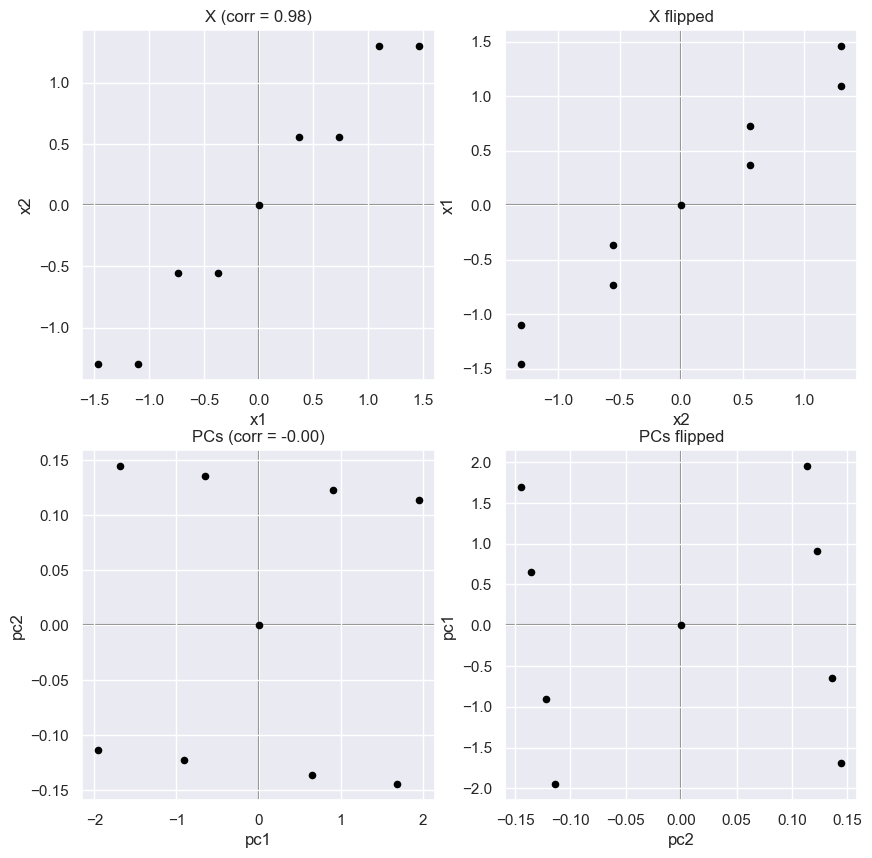

In [3]:
X_train = pd.DataFrame(
    {
        "x1": [-4  , -3  , -2  , -1  , 0, +1  , +2  , +3  , +4  ],
        "x2": [-3.5, -3.5, -1.5, -1.5, 0, +1.5, +1.5, +3.5, +3.5],
    }
)

X_train = _standardize(
    X=X_train,
)

pc_mults = _get_pc_mults(
    X=X_train,
    var_frac=None,
)
pcs_train = calc_pcs(
    X=X_train,
    mults=pc_mults,
)


_, axs = plt.subplots(
    nrows=2,
    ncols=2,
)
####
fsc.plot(
    X_train,
    kind="scatter",
    axvline_locs=[0],
    title=f"""X (corr = {X_train.corr().loc["x1", "x2"] :.2f})""",
    ax=axs[0, 0],
)
fsc.plot(
    X_train[["x2", "x1"]],
    kind="scatter",
    axvline_locs=[0],
    title=f"""X flipped""",
    ax=axs[0, 1],
)
##
fsc.plot(
    pcs_train,
    kind="scatter",
    axvline_locs=[0],
    title=f"""PCs (corr = {pcs_train.corr().loc["pc1", "pc2"] :.2f})""",
    ax=axs[1, 0],
)
fsc.plot(
    pcs_train[["pc2", "pc1"]],
    kind="scatter",
    axvline_locs=[0],
    title=f"""PCs flipped""",
    ax=axs[1, 1],
    figsize=(10, 10),
)
####
plt.show()

In [4]:
del axs, pcs_train, pc_mults, X_train

# DATA

In [5]:
N_QUARTERS: Final[int] = 4

N_TICKERS: Final[int] = 500
N_ASSETCLASSES: Final[int] = 4
N_COUNTRIES: Final[int] = 5
N_SECTORS: Final[int] = 5
# 5 tickers per sector
N_TICKERS_PER_SECTOR: Final[int] = int(
    N_TICKERS
    / N_ASSETCLASSES
    / N_COUNTRIES
    / N_SECTORS
)
assert N_TICKERS_PER_SECTOR == 5, N_TICKERS_PER_SECTOR

# # debug
# N_QUARTERS: Final[int] = 2
# N_TICKERS: Final[int] = 16
# N_ASSETCLASSES: Final[int] = 2
# N_COUNTRIES: Final[int] = 2
# N_SECTORS: Final[int] = 2
# # 2 tickers per sector
# assert N_TICKERS_PER_SECTOR == 2, N_TICKERS_PER_SECTOR

In [6]:
# index
ix__q = (
    sum(
        (
            [f"q{q}"] * N_TICKERS
            for q in range(1, N_QUARTERS+1)
        ),
        start=[],
    )
)
ix__ticker = (
    [
        f"ticker{t}"
        for t in range(1, N_TICKERS+1)
    ]
    * N_QUARTERS
)

ix = pd.MultiIndex.from_frame(
    pd.DataFrame(
        {
            "q": ix__q,
            "ticker": ix__ticker,
        }
    )
)
del ix__ticker, ix__q


ix

MultiIndex([('q1',   'ticker1'),
            ('q1',   'ticker2'),
            ('q1',   'ticker3'),
            ('q1',   'ticker4'),
            ('q1',   'ticker5'),
            ('q1',   'ticker6'),
            ('q1',   'ticker7'),
            ('q1',   'ticker8'),
            ('q1',   'ticker9'),
            ('q1',  'ticker10'),
            ...
            ('q4', 'ticker491'),
            ('q4', 'ticker492'),
            ('q4', 'ticker493'),
            ('q4', 'ticker494'),
            ('q4', 'ticker495'),
            ('q4', 'ticker496'),
            ('q4', 'ticker497'),
            ('q4', 'ticker498'),
            ('q4', 'ticker499'),
            ('q4', 'ticker500')],
           names=['q', 'ticker'], length=2000)

## X

In [7]:
# qualitative features
XNAMES_QUAL: Final[Sequence[str]] = [
    "ac",
    "ccy",
    "sector",
]

x__ac = (
    sum(
        (
            [f"_ac{a}"] * int(N_TICKERS/N_ASSETCLASSES)
            for a in range(1, N_ASSETCLASSES+1)
        ),
        start=[],
    )
    * N_QUARTERS
)
x__ccy = (
    sum(
        (
        
            [f"_ccy{s}"] * int(N_TICKERS/N_ASSETCLASSES/N_COUNTRIES)
            for s in range(1, N_COUNTRIES+1)
        ),
        start=[],
    )
    * N_ASSETCLASSES
    * N_QUARTERS
)
x__sector = (
    sum(
        (
        
            [f"_sector{s}"] * int(N_TICKERS/N_ASSETCLASSES/N_COUNTRIES/N_SECTORS)
            for s in range(1, N_SECTORS+1)
        ),
        start=[],
    )
    * N_COUNTRIES
    * N_ASSETCLASSES
    * N_QUARTERS
)

_dta_qual = pd.DataFrame(
    {
        "q": ix.map(lambda q_ticker: q_ticker[0]),
        "ac": x__ac,
        "ccy": x__ccy,
        "sector": x__sector,
    },
    index=ix,
)
del x__sector, x__ccy, x__ac
cohort = _dta_qual.sum(axis="columns").rename("cohort")


cohort

q   ticker   
q1  ticker1      q1_ac1_ccy1_sector1
    ticker2      q1_ac1_ccy1_sector1
    ticker3      q1_ac1_ccy1_sector1
    ticker4      q1_ac1_ccy1_sector1
    ticker5      q1_ac1_ccy1_sector1
                        ...         
q4  ticker496    q4_ac4_ccy5_sector5
    ticker497    q4_ac4_ccy5_sector5
    ticker498    q4_ac4_ccy5_sector5
    ticker499    q4_ac4_ccy5_sector5
    ticker500    q4_ac4_ccy5_sector5
Name: cohort, Length: 2000, dtype: object

In [8]:
# quantitative features
XNAMES_QUANT: Final[Sequence[str]] = [
    "v",
    "m",
    "c",
    "d",
]

_dta_quant = pd.DataFrame(
    {
        "v": [-8, -2,  0, +2, +8],
        "m": [+1,  0,  0,  0, -1],
        "c": [+1, -1, +1, -1, +1],
        "d": [-2, +1, +1, -2, -4],
    }
)
assert len(_dta_quant) == N_TICKERS_PER_SECTOR, len(dta_quant)
_dta_quant = pd.concat(
    [_dta_quant] * int(N_TICKERS / len(_dta_quant)) * N_QUARTERS,
    ignore_index=True,
).set_index(ix)

_dta_quant_train = _dta_quant.drop(index="q4")
_dta_quant_train = _standardize(
    X=_dta_quant_train
)
_dta_quant_test = _dta_quant.loc[["q4"], :]
_dta_quant_test = _standardize(
    X=_dta_quant_test
)

# dim-reduction
pc_mults_trained = _get_pc_mults(
    X=_dta_quant_train,
)


pc_mults_trained

,v,m,c,d
pc1,0.647373,-0.626404,0.101779,-0.422098
pc2,-0.198760,0.243501,0.826567,-0.466893


In [9]:
dta_quant_train = get_rankstdized(
    X=_dta_quant_train,
    cohort=cohort,
    pc_mults=pc_mults_trained,
)


dta_quant_train

pc1       pc2
q  ticker                       
q1 ticker1   -1.264911  1.264911
   ticker2   -0.632456 -1.264911
   ticker3    0.000000  0.000000
   ticker4    0.632456 -0.632456
   ticker5    1.264911  0.632456
...                ...       ...
q3 ticker496 -1.264911  1.264911
   ticker497 -0.632456 -1.264911
   ticker498  0.000000  0.000000
   ticker499  0.632456 -0.632456
   ticker500  1.264911  0.632456

[1500 rows x 2 columns]

In [10]:
dta_quant_test = get_rankstdized(
    X=_dta_quant_test,
    cohort=cohort,
    pc_mults=pc_mults_trained,
)


dta_quant_test

pc1       pc2
q  ticker                       
q4 ticker1   -1.264911  1.264911
   ticker2   -0.632456 -1.264911
   ticker3    0.000000  0.000000
   ticker4    0.632456 -0.632456
   ticker5    1.264911  0.632456
...                ...       ...
   ticker496 -1.264911  1.264911
   ticker497 -0.632456 -1.264911
   ticker498  0.000000  0.000000
   ticker499  0.632456 -0.632456
   ticker500  1.264911  0.632456

[500 rows x 2 columns]

## y

In [11]:
_y_train = np.sign(
    _dta_quant_train
    .sum(axis="columns")
)
# flip sign w.p. 0.10
is_flip = (
    np.random
    .default_rng(seed=42)
    .choice(
        a=[1   , -1  ],
        p=[0.90, 0.10],
        size=len(_y_train)
    )
)
y_train = _y_train * is_flip
del is_flip
y_train = (np.sign(y_train) > 0).astype(int)


y_train

q   ticker   
q1  ticker1      1
    ticker2      0
    ticker3      1
    ticker4      0
    ticker5      0
                ..
q3  ticker496    1
    ticker497    0
    ticker498    1
    ticker499    0
    ticker500    0
Length: 1500, dtype: int64

In [12]:
y_train.mean()

0.428

In [13]:
_y_test = np.sign(
    _dta_quant_test
    .sum(axis="columns")
)
# flip sign w.p. 0.10
is_flip = (
    np.random
    .default_rng(seed=42)
    .choice(
        a=[1   , -1  ],
        p=[0.90, 0.10],
        size=len(_y_test)
    )
)
y_test = _y_test * is_flip
del is_flip
y_test = (np.sign(y_test) > 0).astype(int)


y_test

q   ticker   
q4  ticker1      1
    ticker2      0
    ticker3      1
    ticker4      0
    ticker5      0
                ..
    ticker496    1
    ticker497    0
    ticker498    1
    ticker499    0
    ticker500    0
Length: 500, dtype: int64

In [14]:
y_test.mean()

0.422

# MODEL

In [15]:
fitter = sklearn.linear_model.LogisticRegression()

In [16]:
fitted = fitter.fit(
    X=dta_quant_train,
    y=y_train,
)


fitted.coef_

array([[-1.66389414,  1.7267521 ]])

In [17]:
y_train_pred = pd.Series(
    fitted.predict_proba(
        X=dta_quant_train,
    )
    [:, 1],
    index=dta_quant_train.index,
)


y_train_pred

q   ticker   
q1  ticker1      0.987138
    ticker2      0.253466
    ticker3      0.512907
    ticker4      0.109799
    ticker5      0.276689
                   ...   
q3  ticker496    0.987138
    ticker497    0.253466
    ticker498    0.512907
    ticker499    0.109799
    ticker500    0.276689
Length: 1500, dtype: float64

In [18]:
y_train_pred.corr(
    y_train
)

0.679132350041216

In [19]:
fitted.score(
    X=dta_quant_train,
    y=y_train,
)

0.8973333333333333

In [20]:
y_test_pred = pd.Series(
    fitted.predict_proba(
        X=dta_quant_test,
    )
    [:, 1],
    index=dta_quant_test.index,
)


y_test_pred

q   ticker   
q4  ticker1      0.987138
    ticker2      0.253466
    ticker3      0.512907
    ticker4      0.109799
    ticker5      0.276689
                   ...   
    ticker496    0.987138
    ticker497    0.253466
    ticker498    0.512907
    ticker499    0.109799
    ticker500    0.276689
Length: 500, dtype: float64

In [21]:
y_test_pred.corr(
    y_test
)

0.7028401979870775

In [22]:
fitted.score(
    X=dta_quant_test,
    y=y_test,
)

0.91

# SCORE

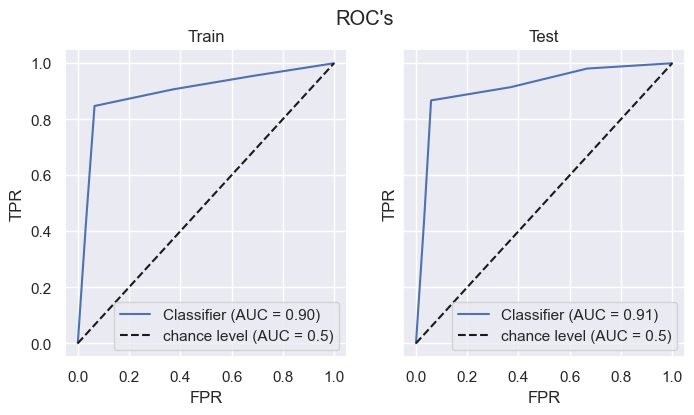

In [23]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
sklearn.metrics.RocCurveDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_train_pred,
    ax=ax,
)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Train")
ax.legend()

ax = axs[1]
sklearn.metrics.RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    ax=ax,
)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Test")
ax.legend()

plt.suptitle("ROC's")
fig.set_size_inches(8, 4)
plt.show()